In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pandas as pd

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from fracdiff.sklearn import Fracdiff,FracdiffStat



# 1. Prepare the data

In [2]:

def prepare_data(path):
    df = pd.read_csv(path)
    df.columns = ['Date_vix']
    df['Date'] = df['Date_vix'].apply(lambda x: x[0:8])
    df['vix'] = df['Date_vix'].apply(lambda x: x[9:])
    df['vix'] = df['vix'].apply(lambda x: str.replace(x, ' ', ''))
    df['vix'] = df['vix'].apply(lambda x: 0.0 if x == '.' else x)
    df['vix'] = df['vix'].astype(float)
    df['log_vix'] = np.log(df['vix'])
    df['Date'] = pd.to_datetime(df['Date'])
    return df


In [3]:
df = prepare_data('./VIXdata.txt')

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
df = df.drop_duplicates()
df.head()

,Date_vix,Date,vix,log_vix
0,20010102 29.99,2001-01-02,29.99,3.400864
2,20010103 26.60,2001-01-03,26.60,3.280911
4,20010104 26.97,2001-01-04,26.97,3.294725
6,20010105 28.67,2001-01-05,28.67,3.355851
8,20010108 29.84,2001-01-08,29.84,3.395850


In [188]:
df = df[df['vix']>0]
df['log_vix_diff'] = df['log_vix'].diff()
df.dropna(inplace=True)
df.head()

,Date_vix,Date,vix,log_vix,log_vix_diff
4,20010104 26.97,2001-01-04,26.97,3.294725,0.013814
6,20010105 28.67,2001-01-05,28.67,3.355851,0.061126
8,20010108 29.84,2001-01-08,29.84,3.395850,0.039998
10,20010109 27.99,2001-01-09,27.99,3.331847,-0.064002
12,20010110 26.80,2001-01-10,26.80,3.288402,-0.043445


In [189]:
df.tail()

,Date_vix,Date,vix,log_vix,log_vix_diff
6185,20220725 23.36,2022-07-25,23.36,3.151025,0.014227
6186,20220726 24.69,2022-07-26,24.69,3.206398,0.055373
6187,20220727 23.24,2022-07-27,23.24,3.145875,-0.060523
6188,20220728 22.33,2022-07-28,22.33,3.105931,-0.039944
6189,20220729 21.33,2022-07-29,21.33,3.060115,-0.045817


In [190]:
d={'Date':df['Date'], 'VIX':df['vix'], 'Log VIX':df['log_vix'], 'Log diff':df['log_vix_diff']}

df_1 = pd.DataFrame(data=d)
df_1 = df_1.drop(df_1.index[:2262])
df_1=df_1.reset_index(drop=True)

In [191]:
df_1.head()

,Date,VIX,Log VIX,Log diff
0,2010-01-05,19.35,2.962692,-0.035038
1,2010-01-06,19.16,2.952825,-0.009868
2,2010-01-07,19.06,2.947592,-0.005233
3,2010-01-08,18.13,2.897568,-0.050024
4,2010-01-11,17.55,2.865054,-0.032514


In [192]:
df_1.tail()

,Date,VIX,Log VIX,Log diff
3162,2022-07-25,23.36,3.151025,0.014227
3163,2022-07-26,24.69,3.206398,0.055373
3164,2022-07-27,23.24,3.145875,-0.060523
3165,2022-07-28,22.33,3.105931,-0.039944
3166,2022-07-29,21.33,3.060115,-0.045817


In [193]:
x = df_1['Log diff']
x.shape

(3167,)

In [194]:
x.values

array([-0.03503786, -0.00986765, -0.00523287, ..., -0.06052337,
       -0.03994387, -0.04581653])

## 1.1. Fracdiff

In [195]:
precision = 10e-8

f = FracdiffStat(window=150, mode="valid", precision=precision, lower=0.0)

diff = f.fit_transform(x.values.reshape(-1,1))

print(f"* Order: {f.d_[0]:.8f}")

* Order: 0.00000000


In [30]:
from fracdiff.sklearn import FracdiffStat

#X = ...  # 2d time-series with shape (n_samples, n_features)

f = FracdiffStat()
xx = f.fit_transform(x.values.reshape(-1,1))
f.d_
# array([0.71875 , 0.609375, 0.515625])

array([0.])

## 1.2. ARIMA

In [31]:
import statsmodels.api as sm

In [32]:
# Fit an ARIMA model and get the fractional difference order
model = sm.tsa.ARIMA(x.values.reshape(-1,1), order=(1, 1, 1))
results = model.fit()
print("Fractional difference order:", results.model_orders)

Fractional difference order: {'trend': 0, 'exog': 0, 'ar': 1, 'ma': 1, 'seasonal_ar': 0, 'seasonal_ma': 0, 'reduced_ar': 1, 'reduced_ma': 1, 'exog_variance': 0, 'measurement_variance': 0, 'variance': 1}


In [33]:
results.model_orders

{'trend': 0,
 'exog': 0,
 'ar': 1,
 'ma': 1,
 'seasonal_ar': 0,
 'seasonal_ma': 0,
 'reduced_ar': 1,
 'reduced_ma': 1,
 'exog_variance': 0,
 'measurement_variance': 0,
 'variance': 1}

# 2. unit root test

## 2.1. ADF statistic

In [34]:
resultADF = sm.tsa.stattools.adfuller(x.values.reshape(-1,1))

# Print the test statistics and p-value
print('ADF Statistic: %f' % resultADF[0])
print('p-value: %f' % resultADF[1])

ADF Statistic: -23.372910
p-value: 0.000000


In [35]:
from arch.unitroot import ADF

In [36]:
adf = ADF(x.values.reshape(-1,1))
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                -23.373
P-value                         0.000
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## 2.2. PP statistic 


In [37]:
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(x.values.reshape(-1,1))
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -65.817
P-value                         0.000
Lags                               29
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## 2.3. KPSS statistic

In [38]:

from arch.unitroot import KPSS

kpss = KPSS(x.values.reshape(-1,1))
print(kpss.summary().as_text())

    KPSS Stationarity Test Results   
Test Statistic                  0.016
P-value                         0.996
Lags                               23
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


In [39]:
from fracdiff.sklearn import FracdiffStat

X=x.values.reshape(-1,1)

f = FracdiffStat()
X = f.fit_transform(X)
f.d_

array([0.])

# Conclusion: the time series X is weakly stationary, thus for I(d) process, d=0.

In [40]:


# Fit an ARIMA model to the time series data
model = sm.tsa.ARIMA(x.values.reshape(-1,1))
results = model.fit()

# Perform a likelihood ratio test on the residual errors
#



In [41]:
print(results.summary().as_text())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3168
Model:                          ARIMA   Log Likelihood                3532.835
Date:                Tue, 09 May 2023   AIC                          -7061.670
Time:                        15:49:30   BIC                          -7049.548
Sample:                             0   HQIC                         -7057.322
                               - 3168                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.014e-05      0.002     -0.007      0.995      -0.003       0.003
sigma2         0.0063   8.53e-05     73.792      0.000       0.006       0.006
Ljung-Box (L1) (Q):                  20.17   Jarque-

In [42]:
print("Fractional difference order:", results.model_orders)

Fractional difference order: {'trend': 0, 'exog': 1, 'ar': 0, 'ma': 0, 'seasonal_ar': 0, 'seasonal_ma': 0, 'reduced_ar': 0, 'reduced_ma': 0, 'exog_variance': 0, 'measurement_variance': 0, 'variance': 1}


In [43]:
# Perform a likelihood ratio test on the residual errors
_, p_value, _, = sm.stats.diagnostic.het_goldfeldquandt(results.resid, results.model.exog)

In [44]:
p_value

4.575663291550559e-06

In [45]:
# If the p-value is less than the desired significance level, there is a changepoint
if p_value < 0.05:
  print("Changepoint detected")
else:
  print("No changepoint detected")

Changepoint detected


In [46]:
resid=results.resid

In [48]:
n = 5
idx = np.argsort(np.abs(resid))[::-1][:n]
print("绝对值最大的前%d个数：" % n)
print(resid[idx])
print("它们的位置：")
print(idx)

绝对值最大的前5个数：
[0.76825515 0.48022428 0.43203018 0.40547525 0.4010209 ]
它们的位置：
[2036 2785 2996  402 1630]


# 1. Prepare the data

In [51]:
pointsARIMA = df_1.iloc[idx, 0]

In [52]:
pointsARIMA

2036   2018-02-05
2785   2021-01-27
2996   2021-11-26
402    2011-08-08
1630   2016-06-24
Name: Date, dtype: datetime64[ns]

In [68]:
import matplotlib.dates as mdates
import datetime as dt

# 2 Detection
## 2.1 Detection based on the ARIMA model

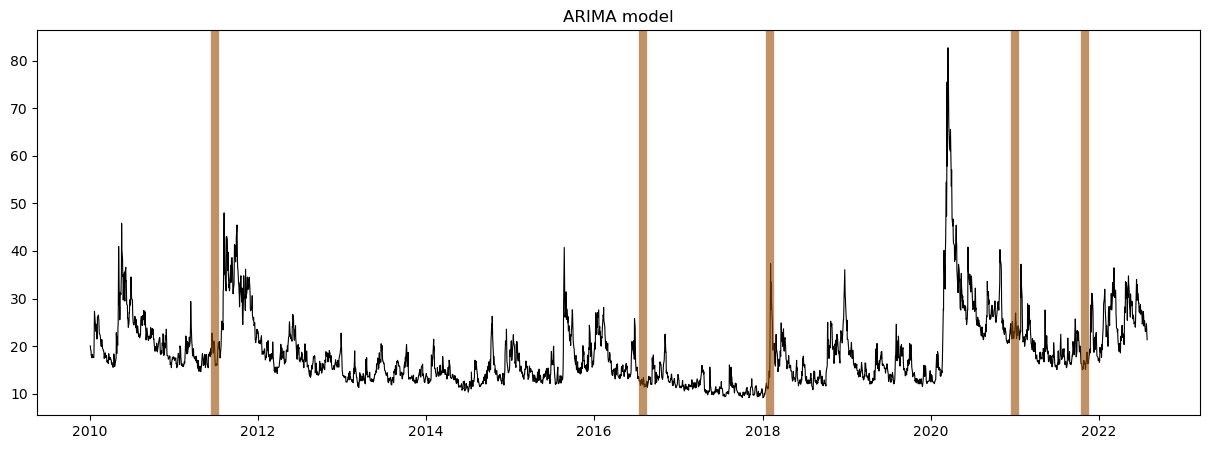

In [181]:
# Detect by ARIMA
# 创建一个新的图形对象和一个子图对象
fig, ax = plt.subplots()

# 绘制一条曲线
x=df_1['Date']
y=df_1['VIX']
ax.plot(x,y,color='black', linewidth=0.8)
ax.set_title('ARIMA model')
line_date1 = dt.date(2018, 2, 1),
line_date2 = dt.date(2021, 1, 1)
line_date3 = dt.date(2021, 11, 1)
line_date4 = dt.date(2011, 7, 1)
line_date5 = dt.date(2016, 8, 1)


# 设置颜色的 RGB 值
color_rgb = '#964B00'

# 绘制竖线
ax.axvline(x=line_date1, color=color_rgb, linewidth=6, alpha=0.6)
ax.axvline(x=line_date2, color=color_rgb, linewidth=6, alpha=0.6)
ax.axvline(x=line_date3, color=color_rgb, linewidth=6, alpha=0.6)
ax.axvline(x=line_date4, color=color_rgb, linewidth=6, alpha=0.6)
ax.axvline(x=line_date5, color=color_rgb, linewidth=6, alpha=0.6)

# 显示图形
fig.set_size_inches(15, 5)
plt.savefig('FIG/ARIMA.png', dpi=300)
# 添加标题

plt.show()

## 2.2 Detection based on the RV model

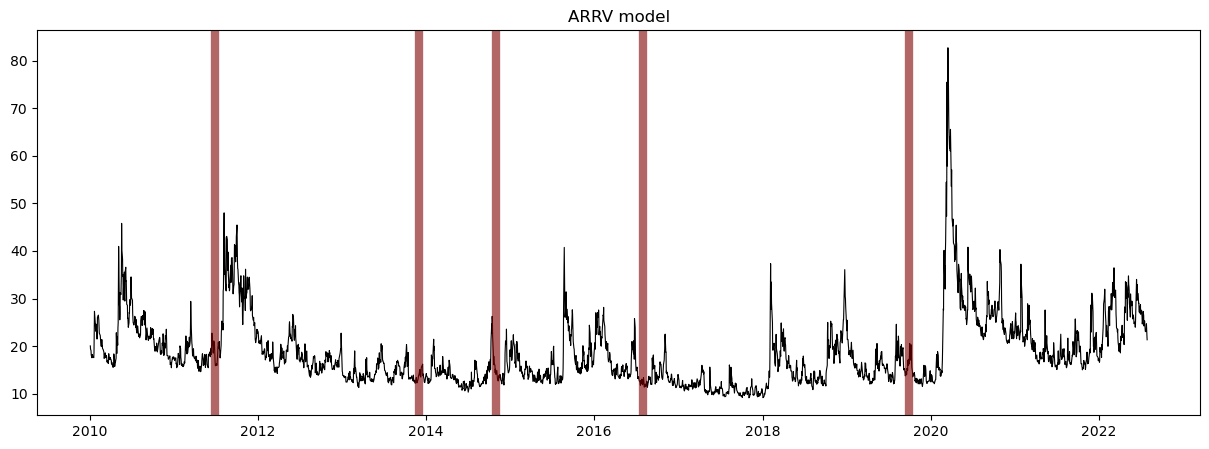

In [180]:
# 创建一个新的图形对象和一个子图对象
fig, ax = plt.subplots()

# 绘制一条曲线
x=df_1['Date']
y=df_1['VIX']
ax.plot(x,y,color='black', linewidth=0.8)
ax.set_title('ARRV model')
line_date1 = dt.date(2011, 7, 1),
line_date2 = dt.date(2013, 12, 1)
line_date3 = dt.date(2014, 11, 1)
line_date4 = dt.date(2016, 8, 1)
line_date5 = dt.date(2019, 10, 1)


# 设置颜色的 RGB 值
color_rgb = '#800000'

# 绘制竖线
ax.axvline(x=line_date1, color=color_rgb, linewidth=6, alpha=0.6)
ax.axvline(x=line_date2, color=color_rgb, linewidth=6, alpha=0.6)
ax.axvline(x=line_date3, color=color_rgb, linewidth=6, alpha=0.6)
ax.axvline(x=line_date4, color=color_rgb, linewidth=6, alpha=0.6)
ax.axvline(x=line_date5, color=color_rgb, linewidth=6, alpha=0.6)

# 显示图形
fig.set_size_inches(15, 5)
plt.savefig('FIG/RV.png', dpi=300)

plt.show()

# CUSUM algorithm

In [162]:
# 使用CUSUM算法找到change points


data = df_1['Log diff']

cusum = np.cumsum(data - np.mean(data))
k, h = np.max(cusum), np.min(cusum)
threshold = 0.55 * (k - h)  # 设置阈值
result = np.where(np.abs(cusum) > threshold)[0]


In [166]:
pointsC=result

In [164]:
df_1['Log diff']

0      -0.078660
1      -0.035038
2      -0.009868
3      -0.005233
4      -0.050024
          ...   
3163    0.014227
3164    0.055373
3165   -0.060523
3166   -0.039944
3167   -0.045817
Name: Log diff, Length: 3168, dtype: float64

In [168]:
pointsCUSUM = df_1.iloc[pointsC, 0]
pointsCUSUM

2564   2020-03-12
2566   2020-03-16
2567   2020-03-17
2568   2020-03-18
2569   2020-03-19
Name: Date, dtype: datetime64[ns]

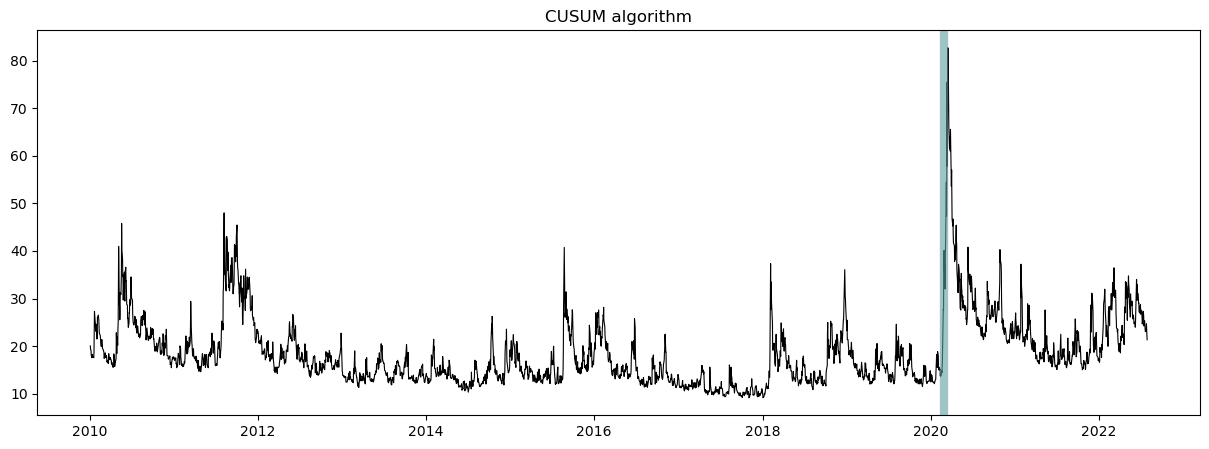

In [179]:
# 创建一个新的图形对象和一个子图对象
fig, ax = plt.subplots()

# 绘制一条曲线
x=df_1['Date']
y=df_1['VIX']
ax.plot(x,y,color='black', linewidth=0.8)
ax.set_title('CUSUM algorithm')
line_date1 = dt.date(2020, 3, 1),


# 设置颜色的 RGB 值
color_rgb = '#5f9ea0'

# 绘制竖线
ax.axvline(x=line_date1, color=color_rgb, linewidth=6, alpha=0.6)


# 显示图形
fig.set_size_inches(15, 5)
plt.savefig('FIG/CUSUM.png', dpi=300)

plt.show()